In [1]:
from dinov2.models import DINOv2

In [2]:
import torch

dinov2 = DINOv2.from_pretrained(
    'KevinCha/dinov2-vit-small-remote-sensing',
    device_map=0,
    torch_dtype=torch.float32,
)
dinov2 = dinov2.eval()

In [3]:
from huggingface_hub import hf_hub_download

In [4]:
from huggingface_hub import hf_hub_download

filename = hf_hub_download(repo_id='KevinCha/dinov2-vit-small-remote-sensing', filename='test.png')
filenames = [filename for _ in range(4)]

In [5]:
from torchvision import transforms
from PIL import Image

In [6]:
transform1 = transforms.Compose([
    transforms.Resize((700, 700)),
    transforms.RandomCrop((672, 672)),
    transforms.RandomRotation(45),
    transforms.GaussianBlur(kernel_size=21),
    transforms.ColorJitter(
        brightness=(0.875, 1.125),
        contrast=(0.5, 1.5),
        saturation=(0.5, 1.5),
        hue=(-0.05, 0.05),
    ),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

In [7]:
patch_h = 672 // 16
patch_w = 672 // 16
feat_dim = 384

In [8]:
total_features = []
for i in range(len(filenames)):
    img = Image.open(filenames[i]).convert('RGB')
    img_t = transform1(img)
    with torch.no_grad():
        outputs = dinov2.student.backbone(img_t.unsqueeze(0).to('cuda'))
        features = outputs.x_norm_patchtokens.cpu()
        total_features.append(features)
total_features = torch.cat(total_features, dim=0)
print(total_features.shape)

torch.Size([4, 1764, 384])


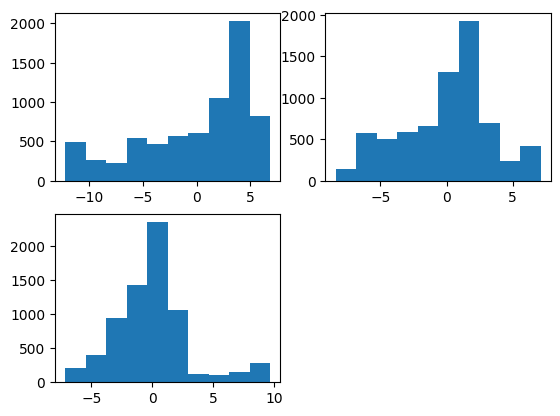

In [9]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# First PCA to Seperate Background
# sklearn expects 2d array for traning
total_features = total_features.reshape(4 * patch_h * patch_w, feat_dim) #4(*H*w, 1024)

pca = PCA(n_components=3)
pca.fit(total_features)
pca_features = pca.transform(total_features)

# visualize PCA components for finding a proper threshold
# 3 histograms for 3 components
plt.subplot(2, 2, 1)
plt.hist(pca_features[:, 0])
plt.subplot(2, 2, 2)
plt.hist(pca_features[:, 1])
plt.subplot(2, 2, 3)
plt.hist(pca_features[:, 2])
plt.show()
plt.close()

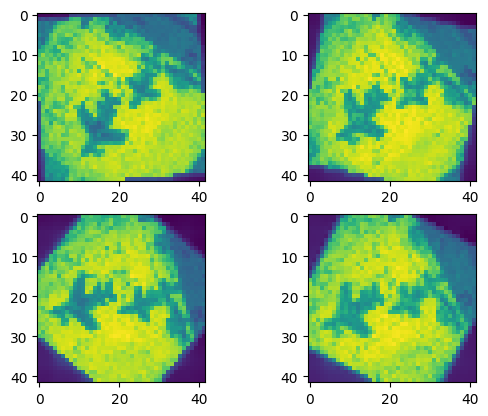

In [10]:
# min_max scale
pca_features[:, 0] = (pca_features[:, 0] - pca_features[:, 0].min()) / \
                     (pca_features[:, 0].max() - pca_features[:, 0].min())
#pca_features = sklearn.processing.minmax_scale(pca_features)

for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.imshow(pca_features[i*patch_h*patch_w : (i+1)*patch_h*patch_w, 0].reshape(patch_h, patch_w))

plt.show()

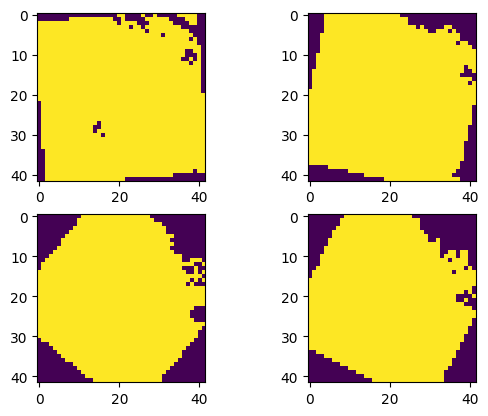

In [11]:
# segment/seperate the backgound and foreground using the first component
pca_features_bg = pca_features[:, 0] > 0.35 # from first histogram
pca_features_fg = ~pca_features_bg

# plot the pca_features_bg
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.imshow(pca_features_bg[i * patch_h * patch_w: (i+1) * patch_h * patch_w].reshape(patch_h, patch_w))
plt.show()

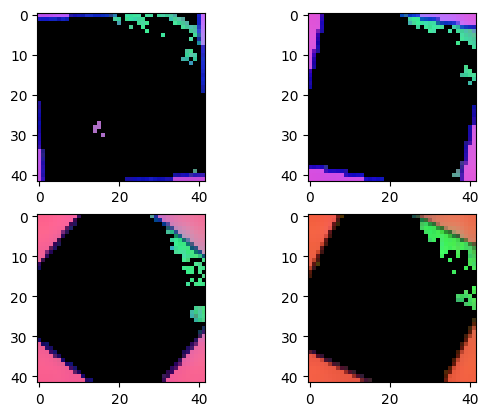

In [12]:
# 2nd PCA for only foreground patches
pca.fit(total_features[pca_features_fg]) 
pca_features_left = pca.transform(total_features[pca_features_fg])

for i in range(3):
    # min_max scaling
    pca_features_left[:, i] = (pca_features_left[:, i] - pca_features_left[:, i].min()) / (pca_features_left[:, i].max() - pca_features_left[:, i].min())

pca_features_rgb = pca_features.copy()
# for black background
pca_features_rgb[pca_features_bg] = 0
# new scaled foreground features
pca_features_rgb[pca_features_fg] = pca_features_left

# reshaping to numpy image format
pca_features_rgb = pca_features_rgb.reshape(4, patch_h, patch_w, 3)
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.imshow(pca_features_rgb[i])

plt.show()